In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)



helper_functions.py already exists, skipping download


In [ ]:
from helper_functions import plot_predictions, plot_decision_boundary, accuracy_fn

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


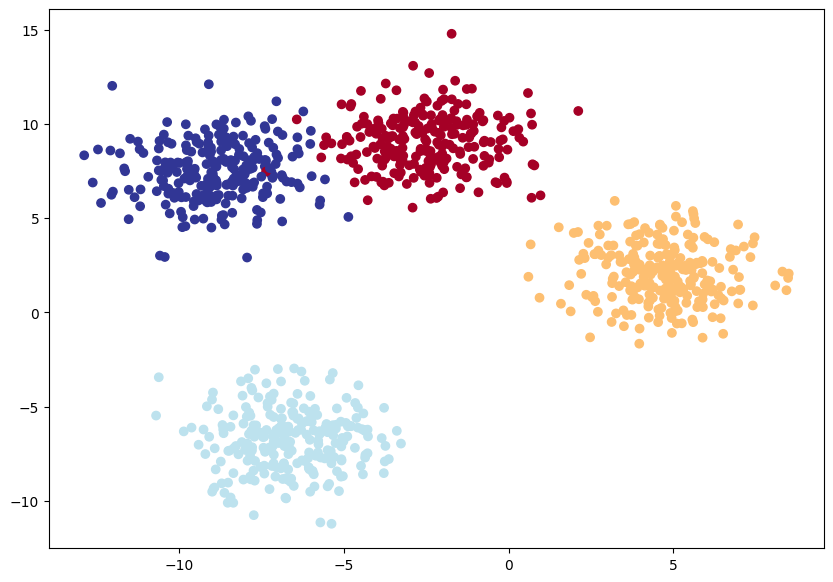

In [ ]:
# set the hyperparams for the data creation

NUM_CLASSES=4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. create a multi class data
X_blob, y_blob = make_blobs(n_samples = 1000,
                            n_features  = NUM_FEATURES, # X features
                            centers = NUM_CLASSES, # y labels
                            cluster_std = 1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
                            random_state = RANDOM_SEED)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. split the data iinto train and test splits
X_blob_train,  X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                      y_blob,
                                                                      test_size=0.2,
                                                                      random_state = RANDOM_SEED)

# 4. Plot the data

plt.figure(figsize = (10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c = y_blob, cmap = plt.cm.RdYlBu)

In [ ]:
len(X_blob_train), len(X_blob_test), len(y_blob_train), len(y_blob_test)

(800, 200, 800, 200)

In [ ]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [ ]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8):
    """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
    """
    super().__init__()
    self.linear_layer_stack  = nn.Sequential(
            nn.Linear(in_features = input_features, out_features = hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [ ]:
# we will now create a loss function

loss_fn = nn.CrossEntropyLoss()
optimizer  = torch.optim.Adam(params = model.parameters(),
                              lr = 0.1)

In [ ]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model(X_blob_train.to(device))[:5]


tensor([[-0.7586, -0.6810, -1.5180, -1.1178],
        [-0.2398, -1.2335, -0.9858, -0.2899],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [ 0.2391, -0.2472,  0.1494,  0.0213],
        [-0.1214, -0.9804, -0.6918, -0.1923]], grad_fn=<SliceBackward0>)

In [ ]:
# How many elements in a single prediction sample?
y_logits = model(X_blob_train.to(device))[0].shape, NUM_CLASSES
y_logits

(torch.Size([4]), 4)

In [ ]:
# lets see how the output look when we pass through  a softmax layer
y_pred_probs = torch.softmax(model(X_blob_test.to(device)), dim = 1)#.argmax(dim=1)
y_pred_probs[:5]

tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], grad_fn=<SliceBackward0>)

In [ ]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0]) # probabilities sum upto 1

tensor(1.0000, grad_fn=<SumBackward0>)

In [ ]:
# Build training loop and test loop for the model

torch.manual_seed(RANDOM_SEED)
epochs = 100

#put the data on the target device
X_blob_train , y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

#
for epoch in range(epochs):
  ###traiining
  model.train()

  #1. Forward pass
  y_logits = model(X_blob_train)
  y_pred  = torch.softmax(y_logits, dim = 1).argmax(dim=1)

  #2. calculate the loss
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true = y_blob_train, y_pred = y_pred)

  # 3. optimizer zero grad
  optimizer.zero_grad()

  # 4. loss.backwrad()
  loss.backward()

  # 5. optimizer step()
  optimizer.step()

  ### Testing

  model.eval()
  with torch.inference_mode():
    # forward pass
    test_logits = model(X_blob_test)
    y_test_pred = test_logits.softmax(dim=1).argmax(dim = 1)
    #calculate the metrix like loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true = y_blob_test, y_pred = y_test_pred)

     # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")





Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 0.81667, Test Acc: 68.50%
Epoch: 10 | Loss: 0.03970, Acc: 98.75% | Test Loss: 0.01952, Test Acc: 99.50%
Epoch: 20 | Loss: 0.03161, Acc: 99.25% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 30 | Loss: 0.02219, Acc: 99.12% | Test Loss: 0.00606, Test Acc: 99.50%
Epoch: 40 | Loss: 0.01999, Acc: 99.50% | Test Loss: 0.00690, Test Acc: 99.50%
Epoch: 50 | Loss: 0.01866, Acc: 99.50% | Test Loss: 0.00842, Test Acc: 99.50%
Epoch: 60 | Loss: 0.01779, Acc: 99.50% | Test Loss: 0.00693, Test Acc: 100.00%
Epoch: 70 | Loss: 0.01723, Acc: 99.38% | Test Loss: 0.00528, Test Acc: 100.00%
Epoch: 80 | Loss: 0.01661, Acc: 99.38% | Test Loss: 0.00442, Test Acc: 100.00%
Epoch: 90 | Loss: 0.01617, Acc: 99.38% | Test Loss: 0.00472, Test Acc: 100.00%


In [ ]:
# Make predictions
model.eval()
with torch.inference_mode():
    y_logits = model(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 11.3431,  27.1547, -24.2326, -13.9541],
        [  6.0207, -34.3325, -11.7430,  13.8259],
        [-16.2332,  -5.7153,  38.2660,   1.5506],
        [  5.3549,  27.2971, -10.7173, -13.8597],
        [ 16.9252,  -2.8993, -36.5995,  -0.5921],
        [  6.3219, -43.7965, -12.3497,  18.0721],
        [-16.0817,   3.8225,  37.8502,  -2.7407],
        [ 13.6539, -10.6345, -29.1558,   2.9715],
        [-17.8163, -19.6533,  41.9472,   7.8578],
        [ 14.5902,  -7.4288, -31.2939,   1.5057]])

In [ ]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 100.0%


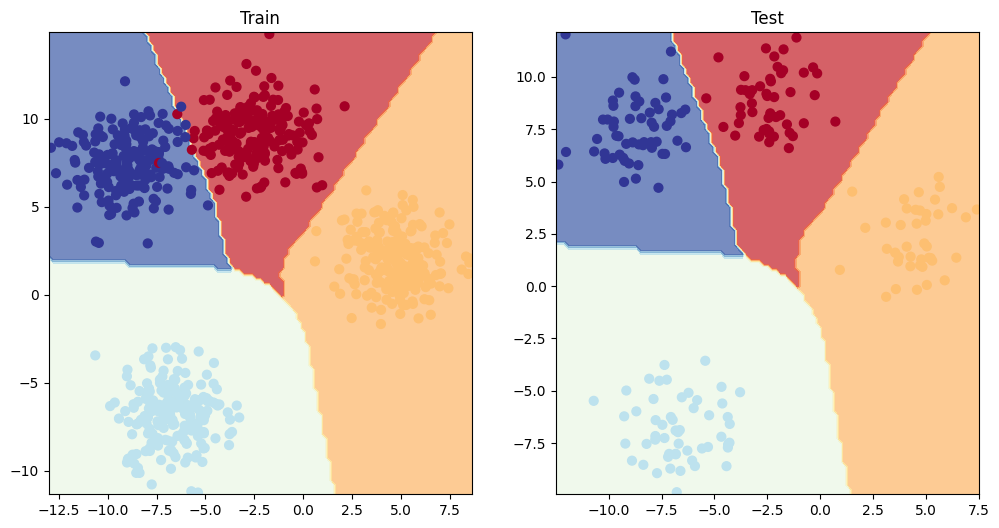

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_blob_test, y_blob_test)

In [ ]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(y_preds, y_blob_test)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.6/419.6 kB 8.9 MB/s eta 0:00:00


tensor(1.)